In [2]:
# Import Packages
import requests
import sys
import geopandas as gpd
import xarray as rxr
import glob
import functionsForDownload
import functionsForPreprocessing
import functions
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import os
import importlib
import functionsForPreprocessing
import matplotlib.pyplot as plt


In [3]:
# Reload the module to update the function definitions
importlib.reload(functionsForPreprocessing)
importlib.reload(functionsForDownload)
importlib.reload(functions)

<module 'functions' from 'c:\\Users\\Stefano\\Desktop\\3_Semester\\TESI\\Python\\Landsat\\functions.py'>

In [4]:
# PARAMETERS DEFINITION SECTION ----------------------------------------------------------------------------------------------------------------------------------
# Define Parameters
AoiShapefilePath = r"C:\Users\Stefano\Desktop\3_Semester\TESI\BBOX\BB_MetropolitanCityOfMilan.shp" #EPSG 32632
output_dir = r"E:\TESI\USGS\DataFilteredByCC"
#output_dir = r"E:\TESI\USGS\DataFilteredByCC_testingEnvironment"
outptNetCDF = r"E:\TESI\USGS\NETCDF_Folder\TEST_file.nc"
lowerLeft, upperRight, aoi = functions.computeBBOX(AoiShapefilePath)
datasetName = "landsat_ot_c2_l2"
catalogNode = "EE"
startDate = "2015-06-27"
endDate = "2024-10-31"
filterid = "61af9273566bb9a8"
downloadDirectory_QA = r"E:\TESI\USGS\QA_PIXEL2"
downloadDirectory = r"E:\TESI\USGS\Final_Data"
downloadFileType = "band"
bandNames = {"QA_PIXEL"}
fileGroupIds = {"ls_c2l2_st_band"}  # Surface temperature
maxThreads = 5
areaThreshold = 98
#inputFolder = r"E:\TESI\USGS\Results"
inputFolder = r"E:\TESI\USGS\DataFilteredByCC"


In [5]:
file_path = r"E:\TESI\USGS\Results2\LC08_L2SP_193028_20150629_20200909_02_T1_ST_B10.TIF"
functions.print_data_info(file_path)

Resolution: (30.0, 30.0) meters per pixel
Coordinate Reference System: EPSG:32632
Bounds: BoundingBox(left=502485.0, bottom=4980285.0, right=734715.0, top=5215815.0)
Raster dimensions: 7741 pixels wide, 7851 pixels tall


In [5]:
# LOGIN SECTION ----------------------------------------------------------------------------------------------------------------------------------
# Define File Paths and Token
token_file_path = r"C:\Users\Stefano\Desktop\3_Semester\TESI\USGS\USGS_TOKEN.txt" # file containing access token to USGS M2M Api
with open(token_file_path, "r") as file:
    token = file.read().strip()

# Define EE M2M API Endpoint
serviceUrl = "https://m2m.cr.usgs.gov/api/api/json/stable/"
login_url = serviceUrl + "login-token"

# Authenticate
payload = {"username": "Stefano98", "token": token} # change this line with your credentials
response = requests.post(login_url, json=payload)
login_results = response.json()

if login_results.get("errorCode"):
    print("Login Error:", login_results["errorMessage"])
    sys.exit(1)
else:
    apiKey = login_results["data"]
    print("Login successful, apiKey:", apiKey)

Login successful, apiKey: eyJjaWQiOjI3MDMzMjE4LCJzIjoiMTczNDQzNDgxOSIsInIiOjcwNSwicCI6WyJ1c2VyIiwiZG93bmxvYWQiLCJvcmRlciJdfQ==


In [7]:
# # Filter Setup - un-comment in order to use it
# dataset_filters_payload = {"datasetName": datasetName, "catalog": catalogNode}
# filters_url = serviceUrl + "dataset-filters"
# filters_response = requests.post(filters_url, headers={"X-Auth-Token": apiKey}, json=dataset_filters_payload)
# filters_results = filters_response.json()
# filterId = filters_results["data"][5]["id"]

# # Pagination Logic for Scene Retrieval
# search_url = serviceUrl + "scene-search"
# headers = {"X-Auth-Token": apiKey}
# starting_number = 0
# page_size = 100
# all_scenes = []

# while True:
#     # Build search payload with filters
#     search_payload = {
#         "datasetName": datasetName,
#         "catalog": catalogNode,
#         "sceneFilter": {
#             "spatialFilter": {
#                 "filterType": "mbr",
#                 "lowerLeft": lowerLeft,
#                 "upperRight": upperRight,
#             },
#             "acquisitionFilter": {"start": startDate, "end": endDate},
#             "metadataFilter": {"filterType": "value", "filterId": filterId, "value": "8"},
#         },
#         "startingNumber": starting_number,
#         "maxResults": page_size,
#     }

#     # Send API request
#     response = requests.post(search_url, headers=headers, json=search_payload)
#     search_results = response.json()

#     # Handle errors
#     if search_results.get("errorCode"):
#         print(f"Search Error: {search_results['errorMessage']}")
#         break

#     # Collect results
#     scenes = search_results.get("data", {}).get("results", [])
#     all_scenes.extend(scenes)
#     print(f"Retrieved {len(scenes)} scenes (starting from {starting_number}).")

#     if len(scenes) < page_size:  # Break if fewer results than page size
#         break
#     starting_number += page_size

# print(f"Total scenes retrieved: {len(all_scenes)}")

Retrieved 100 scenes (starting from 0).
Retrieved 100 scenes (starting from 100).
Retrieved 100 scenes (starting from 200).
Retrieved 100 scenes (starting from 300).
Retrieved 100 scenes (starting from 400).
Retrieved 100 scenes (starting from 500).
Retrieved 100 scenes (starting from 600).
Retrieved 100 scenes (starting from 700).
Retrieved 49 scenes (starting from 800).
Total scenes retrieved: 849


In [ ]:
# # Setup Download Directory - un-comment in order to use it
# functionsForDownload.setupOutputDir(downloadDirectory_QA)

# # Split scene_ids into batches of 100
# scene_ids = [scene["entityId"] for scene in all_scenes]  # Collect scene IDs
# batch_size = 100
# scene_batches = [scene_ids[i:i + batch_size] for i in range(0, len(scene_ids), batch_size)] #same as scene_ids bt divided in [] brachets

# print(f"Total scenes to download: {len(scene_ids)}")
# print(f"Total batches to process: {len(scene_batches)}")

# # Iterate over batches and download
# for batch_num, batch in enumerate(scene_batches):
#     #print(f"Processing batch {batch_num + 1}/{len(scene_batches)} with {len(batch)} scenes.")
#     #print("batch", batch)
#     # Create a payload for the current batch
#     batch_payload = {
#         "datasetName": datasetName,
#         "catalog": catalogNode,
#         "listId": f"temp_landsat_list_{batch_num}",
#         "entityIds": batch,
#     }
#     print("batch_payload", batch_payload)

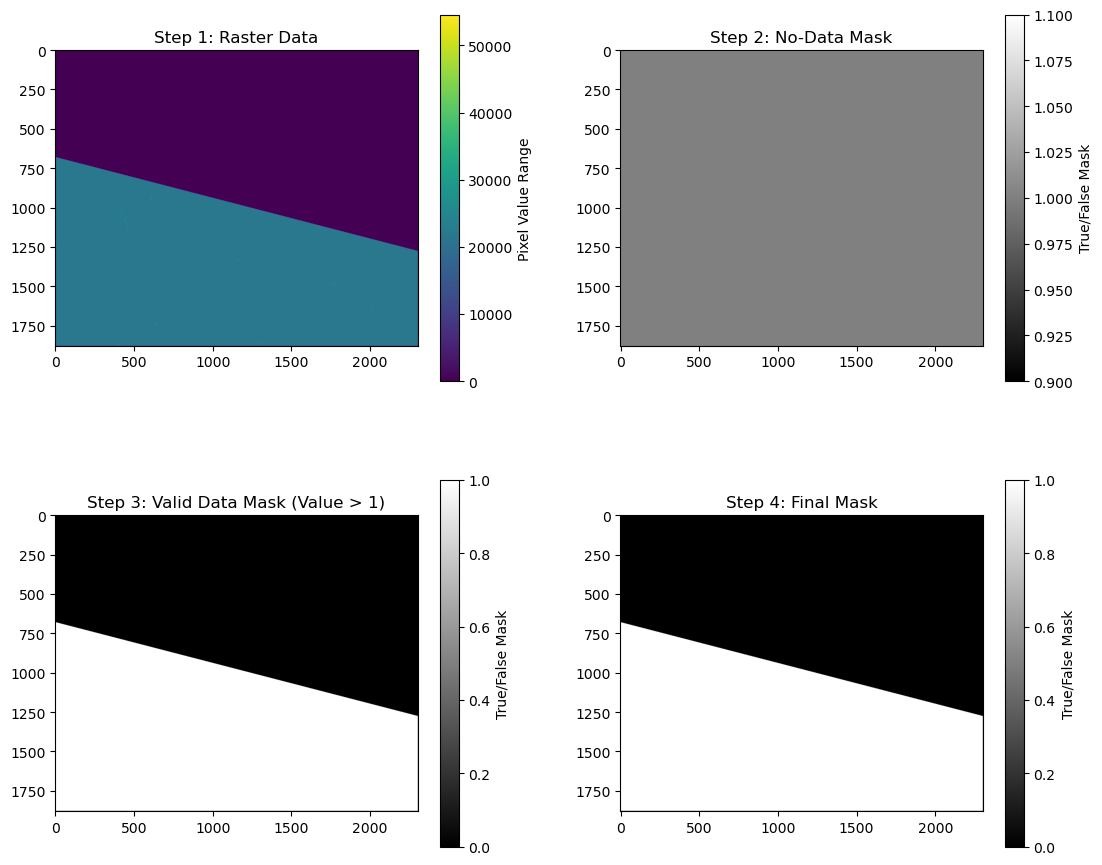

Files with >98% overlap: 80


In [5]:
# COMPUTING OVERLP %  -----------------------------------------------------------------------------------------------------------------------------------
#importlib.reload(functionsForPreprocessing)
# NumberOfImagesAboveThreshold, files_above_threshold = functionsForPreprocessing.compute_overlapping_percentage_with_mask(output_dir, aoi, areaThreshold)
#print(files_above_threshold)

In [7]:
# Setup Download Directory
functionsForDownload.setupOutputDir(downloadDirectory)
# Extract filenames without the "_QA_PIXEL.TIF" part
entityIds = [
    os.path.basename(file).replace("_QA_PIXEL.TIF", "") 
    for file in files_above_threshold
]
# Extract entityIds from the filenames
#entityIds = [os.path.basename(file).split("_")[0] + os.path.basename(file).split("_")[2] + os.path.basename(file).split("_")[2] + for file in files_above_threshold]
print(entityIds)
# Prepare the payload for the download function
payload = {
    "listId": "temp_landsat_download_list",
    "idField": "displayId",
    "entityIds": entityIds,
    "datasetName": datasetName
}

print(payload)

Directory 'E:\TESI\USGS\Final_Data\data' already exists.
Directory 'E:\TESI\USGS\Final_Data\utils' already exists.
['LC08_L2SP_194028_20200601_20200824_02_T1', 'LC08_L2SP_194028_20200820_20200905_02_T1', 'LC08_L2SP_194028_20201124_20210316_02_T1', 'LC08_L2SP_194028_20200905_20200918_02_T1', 'LC08_L2SP_194028_20210316_20210328_02_T1', 'LC08_L2SP_194028_20210228_20210311_02_T1', 'LC08_L2SP_194028_20200719_20200911_02_T1', 'LC08_L2SP_194028_20210111_20210307_02_T1', 'LC08_L2SP_194028_20201226_20210310_02_T1', 'LC08_L2SP_194028_20210519_20210528_02_T1', 'LC08_L2SP_194028_20190530_20200828_02_T1', 'LC08_L2SP_194028_20190428_20200828_02_T1', 'LC08_L2SP_194028_20190701_20200827_02_T1', 'LC08_L2SP_194028_20190717_20200827_02_T1', 'LC08_L2SP_194028_20190818_20200827_02_T1', 'LC08_L2SP_194028_20191005_20200825_02_T1', 'LC08_L2SP_194028_20190903_20200826_02_T1', 'LC08_L2SP_194028_20191208_20200824_02_T1', 'LC08_L2SP_194028_20200414_20200822_02_T1', 'LC08_L2SP_194028_20180425_20200901_02_T1', 'LC0

In [8]:
# Call the download function
importlib.reload(functionsForDownload)
downloadFileType = 'band_group'  # Use "bundle" to download all bands
functionsForDownload.downloadMain(
    url=login_url, 
    maxThreads=maxThreads, 
    downloadFileType=downloadFileType, 
    search_payload=payload, 
    datasetName=datasetName, 
    serviceUrl=serviceUrl, 
    bandNames=None,  # None for all bands
    apiKey=apiKey, 
    fileGroupIds=fileGroupIds, 
    data_dir=downloadDirectory
)

displayId
Using 'displayId' for scene-list-add payload.
{'listId': 'temp_landsat_download_list', 'idField': 'displayId', 'entityIds': ['LC08_L2SP_194028_20200601_20200824_02_T1', 'LC08_L2SP_194028_20200820_20200905_02_T1', 'LC08_L2SP_194028_20201124_20210316_02_T1', 'LC08_L2SP_194028_20200905_20200918_02_T1', 'LC08_L2SP_194028_20210316_20210328_02_T1', 'LC08_L2SP_194028_20210228_20210311_02_T1', 'LC08_L2SP_194028_20200719_20200911_02_T1', 'LC08_L2SP_194028_20210111_20210307_02_T1', 'LC08_L2SP_194028_20201226_20210310_02_T1', 'LC08_L2SP_194028_20210519_20210528_02_T1', 'LC08_L2SP_194028_20190530_20200828_02_T1', 'LC08_L2SP_194028_20190428_20200828_02_T1', 'LC08_L2SP_194028_20190701_20200827_02_T1', 'LC08_L2SP_194028_20190717_20200827_02_T1', 'LC08_L2SP_194028_20190818_20200827_02_T1', 'LC08_L2SP_194028_20191005_20200825_02_T1', 'LC08_L2SP_194028_20190903_20200826_02_T1', 'LC08_L2SP_194028_20191208_20200824_02_T1', 'LC08_L2SP_194028_20200414_20200822_02_T1', 'LC08_L2SP_194028_20180425_20

SystemExit: 

c:\Users\Stefano\anaconda3\envs\Tesi\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [12]:
# Check that you have downloaded all files:
#%tb

# Run the function
functions.list_and_compare_QA_PIXEL_files(downloadDirectory, entityIds)


Total QA_PIXEL files found in folder: 80
Total entityIds in list: 80
Products not in entityIds (0):


In [ ]:
# Inputs
output_folder = r"E:\TESI\USGS\Final_Data_Clipped"  # Folder to save clipped rasters
#file_suffix = "ST_B10.TIF"  # Filter for raster files ending with this suffix
file_suffix = "ST_QA.TIF"  # Filter for raster files ending with this suffix
functionsForPreprocessing.clip_rasters_by_aoi(downloadDirectory, output_folder, file_suffix, AoiShapefilePath)

In [7]:
importlib.reload(functionsForPreprocessing)
importlib.reload(functions)
folder_path = r"E:\TESI\USGS\Final_Data_Clipped"
# suffix = "_ST_B10.TIF"
# for f in os.listdir(folder_path):
#     if f.endswith(suffix):
#         os.path.join(folder_path, f) 
st_b10_files = functions.list_files_in_folder(folder_path, "_ST_B10.TIF")
st_qa_files = functions.list_files_in_folder(folder_path, "_ST_QA.TIF")
output_folder = r"E:\TESI\USGS\Final_Data_Masked"
functionsForPreprocessing.process_temperature_files(st_b10_files, st_qa_files, output_folder, uncertaintyThreshold = 4.5)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
[('E:\\TESI\\USGS\\Final_Data_Clipped\\LC08_L2SP_194028_20210316_20210328_02_T1_ST_B10.TIF', 'E:\\TESI\\USGS\\Final_Data_Clipped\\LC08_L2SP_194028_20210316_20210328_02_T1_ST_QA.TIF'), ('E:\\TESI\\USGS\\Final_Data_Clipped\\LC08_L2SP_194028_20210519_20210528_02_T1_ST_B10.TIF', 'E:\\TESI\\USGS\\Final_Data_Clipped\\LC08_L2SP_194028_20210519_20210528_02_T1_ST_QA.TIF'), ('E:\\TESI\\USGS\\Final_Data_Clipped\\LC08_L2SP_194028_20190530_20200828_02_T1_ST_B10.TIF', 'E:\\TESI\\USGS\\Final_Data_Clipped\\LC08_L2SP_194028_20190530_20200828_02_T1_ST_QA.TIF'), ('E:\\TESI\\USGS\\Final_Data_Clipped\\LC08_L2SP_194028_20190818_20200827_02_T1_ST_B10.TIF', 'E:\\TESI\\USGS\\Final_Data_Clipped\\LC08_L2SP_194028_20190818_20200827_02_T1_ST_QA.TIF'), ('E:\\TESI\\USGS\\Final_Data_Clipped\\LC08_L2SP_194028_20190106_20200830_02_T1_ST_B10.TIF', 'E:\\TESI\\USGS\\Final_Data_Clipp

In [4]:
importlib.reload(functions)
#folder_path = r"E:\TESI\USGS\QA_PIXEL2"
#folder_path = r"E:\TESI\USGS\Results"
folder_path = r"E:\TESI\USGS\DataFilteredByCC"
functions.list_unique_crs(folder_path)

You have 1 different CRS(s): EPSG:32632


In [10]:
import os
import rioxarray
from rasterio import open as rio_open

# Define the path to the folder containing the TIFF files
input_folder = r"E:\TESI\USGS\Final_Data_Masked"

# Get the first TIFF file in the folder
tiff_files = [f for f in os.listdir(input_folder) if f.endswith(".TIF")]
if not tiff_files:
    print("No TIFF files found in the folder.")
else:
    tiff_file = os.path.join(input_folder, tiff_files[0])
    print(f"Inspecting file: {tiff_file}")
    
    # Using rioxarray to open the TIFF file
    da = rioxarray.open_rasterio(tiff_file)
    print("\n--- DataArray Information ---")
    print(da)
    
    # Print CRS information
    print("\n--- CRS Information ---")
    print(da.rio.crs)
    
    # Print spatial extent
    print("\n--- Spatial Extent ---")
    print(da.rio.bounds())
    
    # Print metadata attributes
    print("\n--- Metadata ---")
    print(da.attrs)
    
    # Extract time information (if available in the filename)
    print("\n--- Time Information ---")
    filename = os.path.basename(tiff_file)
    date = filename.split('_')[3]  # Adjust index based on filename structure
    print(f"Date (from filename): {date}")
    
    # Print coordinate values
    print("\n--- Coordinates ---")
    print("X:", da.coords["x"].values)
    print("Y:", da.coords["y"].values)

    # Use rasterio for additional metadata (optional)
    print("\n--- Rasterio Metadata ---")
    with rio_open(tiff_file) as src:
        print(src.profile)


Inspecting file: E:\TESI\USGS\Final_Data_Masked\LC08_L2SP_194028_20210316_20210328_02_T1_ST_B10.TIF

--- DataArray Information ---
<xarray.DataArray (band: 1, y: 1879, x: 2302)> Size: 17MB
[4325458 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 18kB 4.756e+05 4.756e+05 ... 5.446e+05 5.446e+05
  * y            (y) float64 15kB 5.056e+06 5.056e+06 5.056e+06 ... 5e+06 5e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

--- CRS Information ---
EPSG:32632

--- Spatial Extent ---
(475545.0, 4999485.0, 544605.0, 5055855.0)

--- Metadata ---
{'AREA_OR_POINT': 'Area', '_FillValue': nan, 'scale_factor': 1.0, 'add_offset': 0.0}

--- Time Information ---
Date (from filename): 20210316

--- Coordinates ---
X: [475560. 475590. 475620. ... 544530. 544560. 544590.]
Y: [5055840. 5055810. 5055780. ... 4999560. 4999530. 4999500.]

--- Rasterio Metadata ---
{

In [6]:
#importlib.reload(functions)
importlib.reload(functions)
importlib.reload(functionsForPreprocessing)
aoi = aoi.to_crs("EPSG:32632")
bounds = aoi.geometry.total_bounds

aoi_bbox = {
    "min_lon": bounds[0],  # Minimum longitude
    "max_lon": bounds[2],  # Maximum longitude
    "min_lat": bounds[1],  # Minimum latitude
    "max_lat": bounds[3],  # Maximum latitude
}
print (aoi_bbox)
#inputFolder = r"E:\TESI\USGS\Final_Data_Masked"
inputFolder = r"E:\TESI\USGS\Final_Data_Masked_4K"
#functionsForPreprocessing.update_netcdf(inputFolder, outptNetCDF, aoi_bbox)
functionsForPreprocessing.make_netcdf(inputFolder, outptNetCDF)

{'min_lon': 475560.02049999963, 'max_lon': 544575.5321000004, 'min_lat': 4999501.332900001, 'max_lat': 5055848.4606}
Extracted date of current files: 2015-07-22 00:00:00
Extracted date of current files: 2015-08-07 00:00:00
Extracted date of current files: 2015-09-24 00:00:00
Extracted date of current files: 2015-11-27 00:00:00
Extracted date of current files: 2016-03-18 00:00:00
Extracted date of current files: 2016-04-19 00:00:00
Extracted date of current files: 2016-05-21 00:00:00
Extracted date of current files: 2016-06-22 00:00:00
Extracted date of current files: 2016-08-25 00:00:00
Extracted date of current files: 2016-09-26 00:00:00
Extracted date of current files: 2016-10-12 00:00:00
Extracted date of current files: 2017-01-16 00:00:00
Extracted date of current files: 2017-02-17 00:00:00
Extracted date of current files: 2017-04-06 00:00:00
Extracted date of current files: 2017-04-22 00:00:00
Extracted date of current files: 2017-08-12 00:00:00
Extracted date of current files: 20

From now on, the code is used to print details of the products and the created NETCDF

In [7]:
import xarray as xr
output_file = r"E:\TESI\USGS\NETCDF_Folder\TEST_file.nc"
ds = xr.open_dataset(output_file)
print("1:", ds.dims)
print("2:", ds.coords)
print("3:", ds['spatial_ref'])
print("4:", ds.attrs)  # Dataset-level attributes
#print("5:", ds['LST'].attrs)  # Variable-level attributes
print("6:", ds['time'])
#print("7:", ds['LST'].dims)
print("8:", ds['spatial_ref'].attrs)
print("9:", ds)
ds.close()

1: FrozenMappingWarningOnValuesAccess({'time': 80, 'lon': 2589, 'lat': 1486})
2: Coordinates:
  * time     (time) datetime64[ns] 640B 2015-07-22 2015-08-07 ... 2024-07-30
  * lon      (lon) float64 21kB 8.686 8.687 8.687 8.687 ... 9.572 9.572 9.572
  * lat      (lat) float64 12kB 45.66 45.66 45.66 45.66 ... 45.15 45.15 45.15
3: <xarray.DataArray 'spatial_ref' ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    horizontal_datum_name:        World Geodetic System 1984
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
 

In [ ]:
# File path
file_path = r"E:\TESI\USGS\NETCDF_Folder\TEST_file.nc"

# Load NetCDF data
ds = xr.open_dataset(file_path)

# Print dataset structure for reference
print(ds)

# Print latitude and longitude ranges
print("Longitude Range:", ds.lon.min().values, "-", ds.lon.max().values)
print("Latitude Range:", ds.lat.min().values, "-", ds.lat.max().values)

# Print example coordinates
print("Example longitudes:", ds.lon.values[:5])  # First 5 longitude values
print("Example latitudes:", ds.lat.values[:5])  # First 5 latitude values


<xarray.Dataset> Size: 1GB
Dimensions:      (time: 80, lon: 2589, lat: 1486)
Coordinates:
  * time         (time) datetime64[ns] 640B 2015-07-22 2015-08-07 ... 2024-07-30
  * lon          (lon) float64 21kB 8.686 8.687 8.687 ... 9.572 9.572 9.572
  * lat          (lat) float64 12kB 45.66 45.66 45.66 ... 45.15 45.15 45.15
Data variables:
    spatial_ref  int32 4B ...
    LST          (time, lat, lon) float32 1GB ...
Attributes:
    title:        Land Surface Temperature
    description:  Dataset of combined TIFF images from Landsat 8 of the 10th ...
    crs:          EPSG:4326
Longitude Range: 8.686287453167681 - 9.572385200752406
Latitude Range: 45.1476275334485 - 45.65607233838023
Example longitudes: [8.68628745 8.68662984 8.68697223 8.68731461 8.687657  ]
Example latitudes: [45.65607234 45.65572995 45.65538756 45.65504518 45.65470279]


In [9]:
# Ensure the main variable is assigned to `da`
da = ds['LST']  # Replace 'LST' with the correct variable name if it's different

# Procedure 1: Pull out data for all 2015
data_2015 = da.sel(time="2015")
print("Data for 2015:", data_2015)

Data for 2015: <xarray.DataArray 'LST' (time: 4, lat: 1486, lon: 2589)> Size: 62MB
[15389016 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 32B 2015-07-22 2015-08-07 ... 2015-11-27
  * lon      (lon) float64 21kB 8.686 8.687 8.687 8.687 ... 9.572 9.572 9.572
  * lat      (lat) float64 12kB 45.66 45.66 45.66 45.66 ... 45.15 45.15 45.15
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Land Surface Temperature
    units:          Kelvin
    grid_mapping:   spatial_ref


In [10]:
# Procedure 2: Pull out data for specific geographical locations
# Use valid coordinates from your data
lon_valid = [8.7, 9.0]  # Replace with a valid longitude range from your dataset
lat_valid = [45.2, 45.6]  # Replace with a valid latitude range from your dataset

location_data = da.sel(lon=lon_valid, lat=lat_valid, method="nearest")
print("Data for specific locations:", location_data)

Data for specific locations: <xarray.DataArray 'LST' (time: 80, lat: 2, lon: 2)> Size: 1kB
[320 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 640B 2015-07-22 2015-08-07 ... 2024-07-30
  * lon      (lon) float64 16B 8.7 9.0
  * lat      (lat) float64 16B 45.2 45.6
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Land Surface Temperature
    units:          Kelvin
    grid_mapping:   spatial_ref


In [11]:
# Procedure 3: Pull out data for specific geographical locations and period
location_data_2015 = da.sel(time="2015", lon=lon_valid, lat=lat_valid, method="nearest")
print("Data for specific locations in 2015:", location_data_2015)

Data for specific locations in 2015: <xarray.DataArray 'LST' (lat: 2, lon: 2)> Size: 16B
[4 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2015-07-22
  * lon      (lon) float64 16B 8.7 9.0
  * lat      (lat) float64 16B 45.2 45.6
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Land Surface Temperature
    units:          Kelvin
    grid_mapping:   spatial_ref


In [12]:
# Procedure 4: Pull out data within a geographical bounding box
lat_min, lat_max = 45.4, 45.6  # Replace with valid latitude bounds
lon_min, lon_max = 9.3, 9.5  # Replace with valid longitude bounds
bbox_data = da.where(
    (da.lat >= lat_min) & (da.lat <= lat_max) &
    (da.lon >= lon_min) & (da.lon <= lon_max),
    drop=True
)
print("Data within bounding box:", bbox_data)

Data within bounding box: <xarray.DataArray 'LST' (time: 80, lat: 584, lon: 584)> Size: 109MB
array([[[322.47134, 322.55338, 322.56363, ..., 320.2633 , 321.00845,
         321.7946 ],
        [322.40982, 322.47134, 322.45767, ..., 320.2223 , 320.86145,
         321.54507],
        [322.4235 , 322.43716, 322.40982, ..., 320.33167, 320.86487,
         321.33658],
        ...,
        [313.0684 , 312.41895, 311.15088, ..., 315.59088, 315.30377,
         315.02008],
        [314.86282, 313.37943, 312.7163 , ..., 315.83356, 315.60455,
         315.4234 ],
        [316.21295, 314.5723 , 314.1177 , ..., 315.96344, 315.89508,
         315.77887]],

       [[319.01575, 319.05676, 319.0055 , ..., 318.48593, 319.15588,
         319.8839 ],
        [318.7081 , 318.77646, 318.79697, ..., 318.1544 , 318.79697,
         319.63782],
        [318.52353, 318.5748 , 318.62265, ..., 317.54257, 317.95956,
         318.86533],
...
        [316.7359 , 316.91708, 315.06793, ..., 310.416  , 309.19577,
        

Data for specific time: <xarray.DataArray 'LST' (lat: 1486, lon: 2589)> Size: 15MB
[3847254 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2016-03-18
  * lon      (lon) float64 21kB 8.686 8.687 8.687 8.687 ... 9.572 9.572 9.572
  * lat      (lat) float64 12kB 45.66 45.66 45.66 45.66 ... 45.15 45.15 45.15
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Land Surface Temperature
    units:          Kelvin
    grid_mapping:   spatial_ref


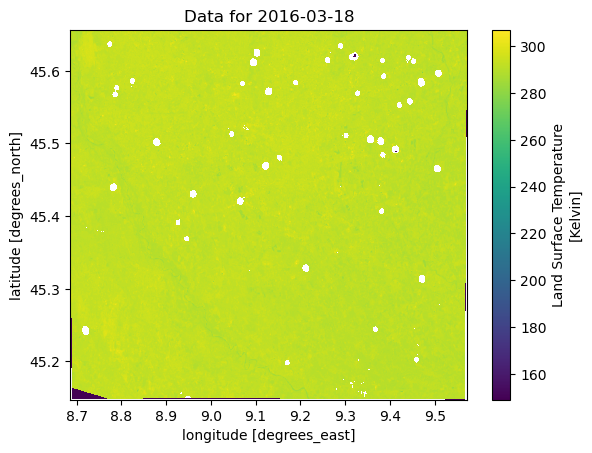

In [16]:
# Procedure 5: Plot data for a specific time
specific_time = "2016-03-18"  # Replace with a valid timestamp from your data
specific_time_data = da.sel(time=specific_time)
print("Data for specific time:", specific_time_data)
specific_time_data.plot()
plt.title(f"Data for {specific_time}")
plt.show()

Time series for specific location: <xarray.DataArray 'LST' (time: 80)> Size: 320B
[80 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 640B 2015-07-22 2015-08-07 ... 2024-07-30
    lon      float64 8B 8.9
    lat      float64 8B 45.3
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Land Surface Temperature
    units:          Kelvin
    grid_mapping:   spatial_ref


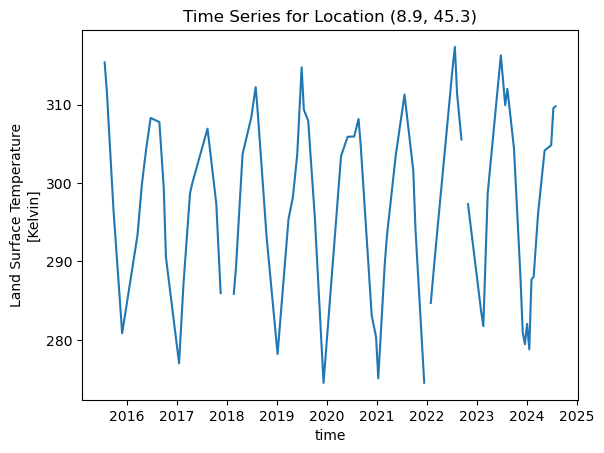

In [17]:
# Procedure 6: Plot data over time for a specific geographical location
lon_point = 8.9  # Replace with a valid longitude
lat_point = 45.3  # Replace with a valid latitude

location_time_series = da.sel(lon=lon_point, lat=lat_point, method="nearest")
print("Time series for specific location:", location_time_series)
location_time_series.plot()
plt.title(f"Time Series for Location ({lon_point}, {lat_point})")
plt.show()

# Close the dataset
ds.close()

In [ ]:
#importlib.reload(functions)
functions.plot_temporal_gaps(files_above_threshold)

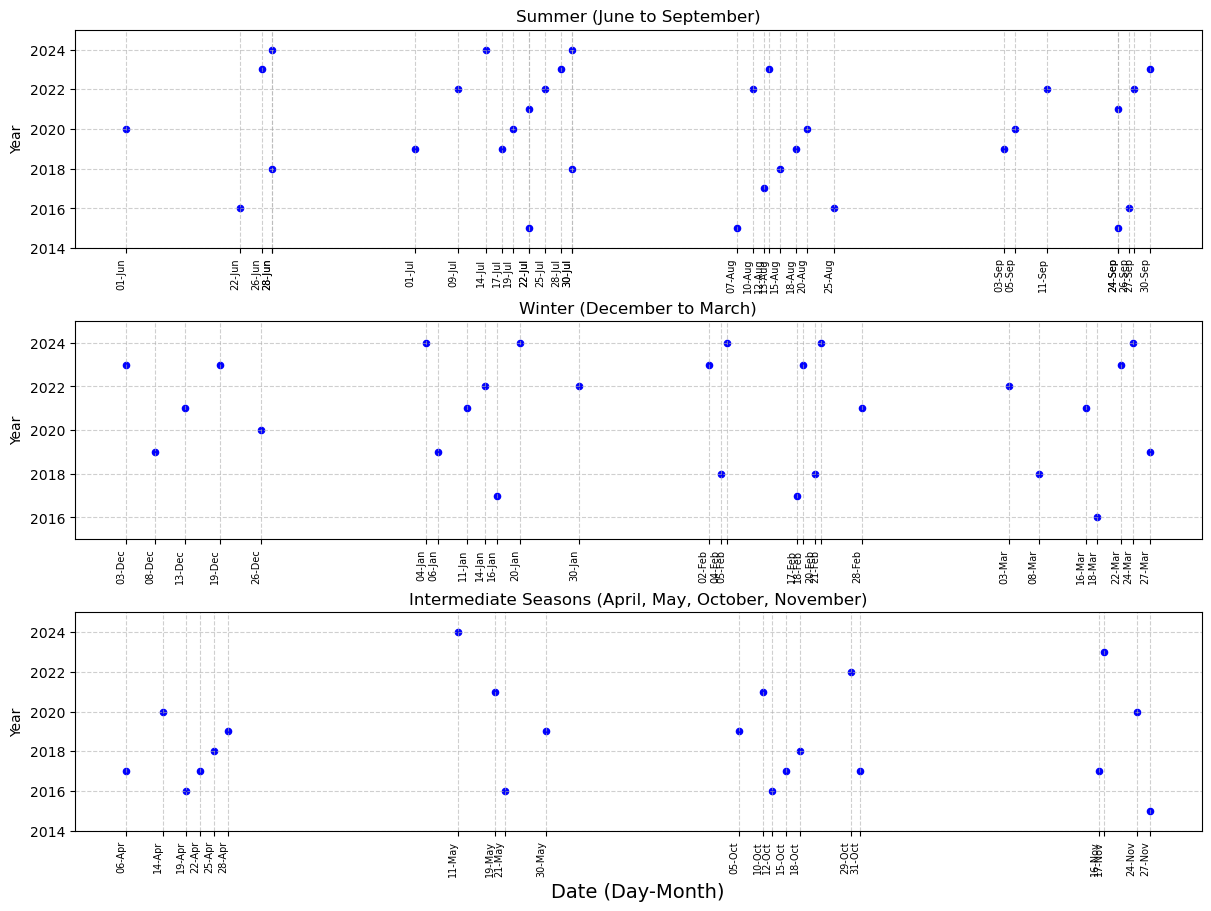

In [36]:
#importlib.reload(functions)
functions.plot_seasonal_temporal_gaps(files_above_threshold)

In [ ]:
#LOGOUT SECTION ----------------------------------------------------------------------------------------------------------------------------------
# Logout
logout_url = serviceUrl + "logout"
if functionsForDownload.sendRequest(logout_url, None, apiKey) is None:
    print("\nLogged Out\n")
else:
    print("\nLogout Failed\n")

In [ ]:
import xarray as xr

xr.backends.file_manager.clear_cache()

# Ensure the file is closed
ds = xr.open_dataset("E:\\TESI\\USGS\\NETCDF_Folder\\TEST_file.nc")
ds.close()
